In [2]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os
import matplotlib
import igraph
from collections import Counter
import networkx as nx
from sklearn import preprocessing

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from helpers import infodynamics
import seaborn as sns
from helpers.networks import *
import helpers.linkage as lkg
from helpers import style 
from helpers import metrics as mc
from helpers import infodynamics
from helpers.infodynamics import diachronic_correlations_lookback

import statsmodels.api as smapi
import statsmodels.graphics as smgraphics

style.load_style()

cf = yaml.safe_load(Path('config.yml').read_text())


import warnings
warnings.filterwarnings("ignore")

In [3]:
data = dataloader.load(cf,agg_level='speech',model_type='lda')
dists = data['dists']
labels = data['labels']
words = data['words']

cab_ = pd.read_csv('helpers/cabinets-merged.csv',sep='\t')
cab_['startdate'] = pd.to_datetime(cab_.startdate,infer_datetime_format=True)
cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)

indices_nonsem = [k for k,v in labels.items() if 'rhet' in v or 'proc' in v]
labels_reverse =dict(zip(labels.values(),labels.keys()))

# Calculate Diachronic Betweenness / Degree for Topics

In [6]:
topic_prominences = []
for (y,h),_ in dists.groupby([dists.index.year,(dists.index.month-1)//2]):
    if len(_) > 10:
        _ = _.mean().reset_index()
        _.columns = ['topic','p']
        _['date'] = pd.Timestamp(year=y,month=(h+1) * 2,day=1)
        topic_prominences.append(_)
topic_prominences = pd.concat(topic_prominences).pivot(index='date',columns='topic',values='p')

In [7]:
d_arrays = {pd.Timestamp(year=y,month=(h+1) * 2,day=1):_.to_numpy() for (y,h),_ in dists.groupby([dists.index.year,(dists.index.month-1)//2]) if len(_) > 10}

r = []
for c,(date,theta) in enumerate(d_arrays.items()):
    theta = mutual_information(theta)[0]
    g,comm,edge_df = get_network_from_mi_theta(mi_theta=theta,weight_threshold=0,weighted=False,node_text='labels',labels=labels)
    btw = dict(get_betweenness_values(g))
    deg = dict(get_degree_values(g))
    av_degree = igraph.mean(g.degree())
    r += [{"top":l,"btw":btw[l],"deg":deg[l],"date":date} for l in btw.keys()]
date_topic_metrics = pd.DataFrame(r)

In [8]:
def get_timeseries(date_topic_metrics,topic_prominence_df,topic_label):
    target_rd = date_topic_metrics[date_topic_metrics.top == topic_label].set_index('date')
    target_rd['topic_prominence'] = topic_prominence_df[[k for k,v in labels.items() if v == topic_label][0]]
    return target_rd

In [9]:
res = []
for l in tqdm(labels.values()):
    r_ = get_timeseries(date_topic_metrics=date_topic_metrics,topic_prominence_df=topic_prominences,topic_label=l)
    timestamps = r_.index.tolist()
    window = 4
    for slice in [timestamps[wd:wd+window] for wd in range(window,len(timestamps) - window)]:
        tdf = r_[r_.index.isin(slice)]
        cr = np.corrcoef(tdf['btw'],tdf['topic_prominence'])[0,1]
        res.append({"topic":l,"slice_start":slice[0],"cr":cr})
res = pd.DataFrame(res)

100%|██████████| 100/100 [00:04<00:00, 23.46it/s]


In [10]:
res.groupby('topic').mean().sort_values('cr',ascending=True).head(15)

,cr
topic,
rhet-18,-0.578504
indonesia-2,-0.547073
economic development,-0.506280
municipal affairs-2,-0.462443
education,-0.446603
proc-12,-0.446356
housing,-0.428287
international conflict,-0.427239
social work,-0.426104


In [14]:
res

,topic,slice_start,cr
0,proc-10,1946-12-01,-0.630613
1,proc-10,1947-02-01,-0.731554
2,proc-10,1947-04-01,0.889566
3,proc-10,1947-06-01,0.972720
4,proc-10,1947-08-01,0.973371
...,...,...,...
11095,rhet-4,1965-08-01,-0.756919
11096,rhet-4,1965-10-01,-0.861686
11097,rhet-4,1965-12-01,-0.655454
11098,rhet-4,1966-02-01,-0.429284


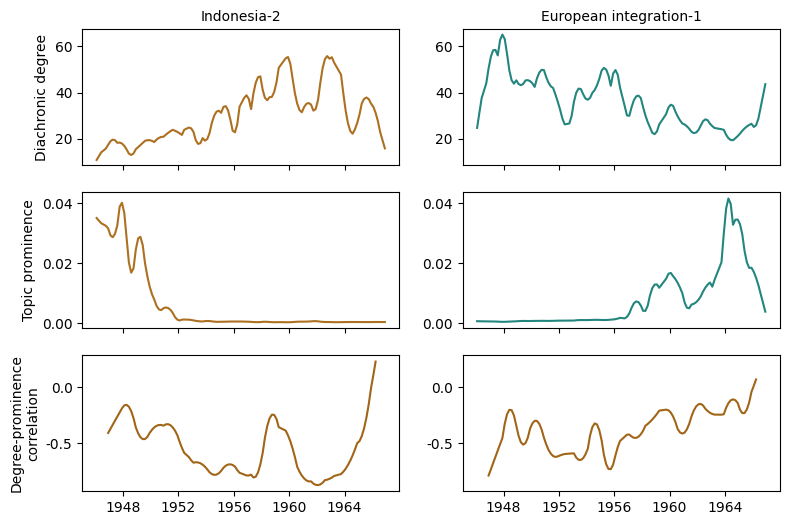

In [13]:
fig,axs = plt.subplots(3,2,sharex=True,figsize=(9,6))
tps = ['indonesia-2','european integration-1']
metric = ['diachronic degree','topic prominence','degree-prominence\ncorrelation']

c1,c2 = sns.color_palette('BrBG',5)[0],sns.color_palette('BrBG',5)[-1]
colors = [c1,c2]

for c,tp in enumerate(tps):
    
    ts_prom_deg = get_timeseries(date_topic_metrics=date_topic_metrics,topic_prominence_df=topic_prominences,topic_label=tp)
    axs[0,c].plot(ts_prom_deg.index,adaptive_filter(ts_prom_deg.btw),color=colors[c])
    axs[1,c].plot(ts_prom_deg.index,adaptive_filter(ts_prom_deg.topic_prominence),color=colors[c])

    ts_corr = res[res.topic == tp]
    axs[2,c].plot(ts_corr.slice_start,adaptive_filter(ts_corr.cr,span=28))

for i in range(3):
    ymin = min([axs[i,i2].get_ylim()[0] for i2 in range(2)])
    ymax = max([axs[i,i2].get_ylim()[1] for i2 in range(2)])
    axs[i,0].set_ylim(ymin,ymax)
    axs[i,1].set_ylim(ymin,ymax)

cols = [tps[col].capitalize() for col in range(0, 2)]
rows = [metric[row] for row in range(0,3)]

for ax, col in zip(axs[0], cols):
    ax.set_title(col.capitalize())

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row.capitalize(), rotation=90,size='small')

In [ ]:
## Top 5 meest verbonden topics door tijd heen, diversiteit/stabiliteit door tijd
## Plot correlatie over tijd tussen prominence / degree (later)
## Plot ranking (later)
## General degree penalty? Correlatie prominence-degree kan hoog zijn, maar als algemene degree laag is, zegt t niet zoveel

# Rank Turbulence Divergence Top _N_ Closest Topics

In [13]:
from helpers import rtd

In [36]:
target_topic_id = 'government spending'
edge_df_arrays = {k:get_network_from_mi_theta(mi_theta=v,weight_threshold=0,weighted=False,node_text='labels',labels=labels)[2] for k,v in mi_arrays.items()}
timestamps = list(edge_df_arrays.keys())

In [37]:
window = 4

res = []
for i in range(window,len(timestamps)-window):

    target_edge_df = edge_df_arrays[timestamps[i]]
    target_edge_df = target_edge_df[(target_edge_df.source == target_topic_id) | (target_edge_df.target == target_topic_id)].sort_values('weight')
    top_connections = [i if i != target_topic_id else j for i,j in zip(target_edge_df.source,target_edge_df.target)][:25 if len(target_edge_df) >= 25 else len(target_edge_df)]
    
    rtd_cum = []

    for i2 in range(i-window,i):
        temp_edf = edge_df_arrays[timestamps[i2]]
        temp_edf = temp_edf[(temp_edf.source == target_topic_id) | (temp_edf.target == target_topic_id)].sort_values('weight')
        top_connectionse_temp = [i if i != target_topic_id else j for i,j in zip(temp_edf.source,temp_edf.target)][:25 if len(temp_edf) >= 25 else len(temp_edf)]
        rtd_cum.append(rtd.rank_turbulence_divergence(top_connections,top_connectionse_temp))
    rtd_ = sum(rtd_cum) / len(rtd_cum)
    res.append({"date":timestamps[i].strftime('%Y-%m'),"rtd_":rtd_})


<AxesSubplot: xlabel='date'>

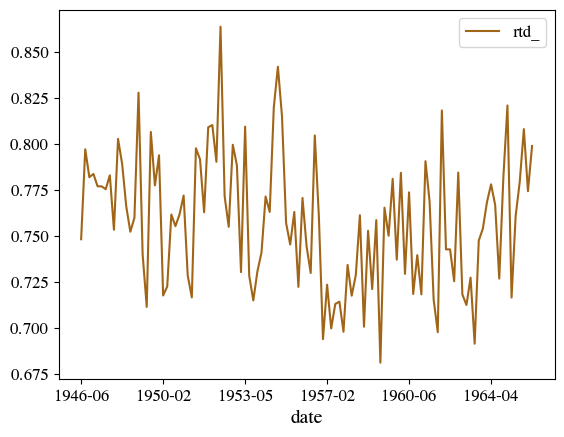

In [38]:
pd.DataFrame(res).plot(x='date',y='rtd_')

In [26]:
edge_df_arrays[timestamps[0]]

,source,target,weight
4,proc-10,civil service wages,0.148148
5,proc-10,war reparations,1.060011
9,proc-10,proc-3,0.496020
12,proc-10,postal service and traffic,1.912353
16,proc-10,proc-8,0.264870
...,...,...,...
9396,proc-7,proc-5,0.253243
9596,civil service,proc-5,0.192892
9598,civil service,public health,1.306021
9698,proc-5,public health,0.946813


In [27]:
edge_df_arrays[timestamps[4]]

,source,target,weight
4,proc-10,civil service wages,0.148148
5,proc-10,war reparations,1.060011
9,proc-10,proc-3,0.496020
12,proc-10,postal service and traffic,1.912353
16,proc-10,proc-8,0.264870
...,...,...,...
9396,proc-7,proc-5,0.253243
9596,civil service,proc-5,0.192892
9598,civil service,public health,1.306021
9698,proc-5,public health,0.946813


In [21]:
top_connectionse_temp

['employment',
 'public insurances',
 'new guinea',
 'prices and cartels',
 'development aid',
 'rhet-3',
 'families-2',
 'proc-8',
 'rhet-10',
 'coalition politics',
 'proc-1',
 'rhet-13',
 'rhet-1',
 'rhet-2',
 'rhet-5',
 'rhet-16',
 'international conflict']

In [1]:
t = '/home/rb/Documents/GitHub/Mallet/bin/mallet train-topics --input text-speech-level-bound.mallet --num-topics 250 --inferencer-filename model-speech-bound-250 --output-topic-keys keys-speech-bound-250 --output-doc-topics dists-speech-bound-250 --topic-word-weights-file ww-speech-bound-250 --diagnostics-file diag-speech-bound-250 --optimize-interval 10'

In [3]:
for i in range(75,476,50):
    print(t.replace('250',str(i)))

/home/rb/Documents/GitHub/Mallet/bin/mallet train-topics --input text-speech-level-bound.mallet --num-topics 75 --inferencer-filename model-speech-bound-75 --output-topic-keys keys-speech-bound-75 --output-doc-topics dists-speech-bound-75 --topic-word-weights-file ww-speech-bound-75 --diagnostics-file diag-speech-bound-75 --optimize-interval 10
/home/rb/Documents/GitHub/Mallet/bin/mallet train-topics --input text-speech-level-bound.mallet --num-topics 125 --inferencer-filename model-speech-bound-125 --output-topic-keys keys-speech-bound-125 --output-doc-topics dists-speech-bound-125 --topic-word-weights-file ww-speech-bound-125 --diagnostics-file diag-speech-bound-125 --optimize-interval 10
/home/rb/Documents/GitHub/Mallet/bin/mallet train-topics --input text-speech-level-bound.mallet --num-topics 175 --inferencer-filename model-speech-bound-175 --output-topic-keys keys-speech-bound-175 --output-doc-topics dists-speech-bound-175 --topic-word-weights-file ww-speech-bound-175 --diagnosti

In [4]:
import shutil
import matplotlib

shutil.rmtree(matplotlib.get_cachedir())